## Imports

In [251]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_selector
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [252]:
open_shot = pd.read_csv('data/clean/open_shot.csv')
open_shot.head()

,game_id,matchup,location,win,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,closest_defender,closest_defender_id,close_def_dist,fgm,pts,player_name,player_id,defender_wingspan,close_def_dist_in,open_shot
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,81.50,15.6,0
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,82.76,73.2,1
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,82.76,10.8,0
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,80.75,40.8,1
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,83.50,13.2,0


In [253]:
open_shot['open_shot'].value_counts()

open_shot
1    68986
0    59083
Name: count, dtype: int64

In [254]:
player_info = pd.read_csv('data/clean/player_info.csv')
player_info.head()

,nba_id,position,first,last,height,weight,draft_year,pos1,pos2,wingspan,standing_reach
0,101187,Forward-Guard,Alan,Anderson,78.0,220.0,NaN,F,G,81.50,104.0
1,202711,Forward,Bojan,Bogdanovic,79.0,226.0,2011.0,F,NaN,82.76,NaN
2,203900,Guard,Markel,Brown,75.0,190.0,2014.0,G,NaN,80.75,100.0
3,201152,Forward,Thaddeus,Young,80.0,225.0,2007.0,F,NaN,83.50,106.0
4,101114,Guard,Deron,Williams,75.0,200.0,2005.0,G,NaN,78.25,98.0


In [255]:
player_size = pd.read_csv('data/clean/player_size.csv')
player_size.head()

,first,last,draft_year,pos1,pos2,height,weight,wingspan,standing_reach
0,Ochai,Agbaji,2022,G,NaN,76.0,217.0,82.25,104.0
1,Patrick,Baldwin Jr.,2022,F,NaN,81.0,231.0,85.75,110.5
2,Dominick,Barlow,2022,F,NaN,81.0,221.0,87.00,108.5
3,MarJon,Beauchamp,2022,G,NaN,77.0,197.0,84.75,106.0
4,Hugo,Besson,2022,G,NaN,76.0,180.0,77.50,102.0


## EDA

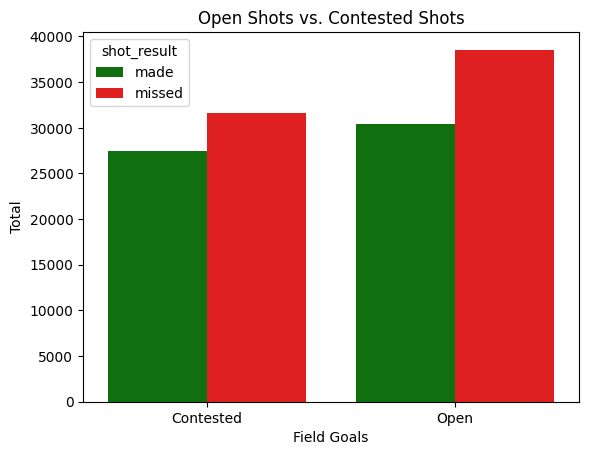

In [256]:
sns.countplot(x="open_shot", hue="shot_result", data=open_shot, palette=['green', 'red'])
plt.title('Open Shots vs. Contested Shots')
plt.xticks([0,1],['Contested','Open'])
plt.xlabel('Field Goals')
plt.ylabel('Total')
# plt.legend(['Missed','Made'])
plt.show()

The above graph analyzes the number of contested and open shots that were made and missed. We can see that there were more shots that were considered to be "open" meaning the distance of the defender to the shooter was greater than or equal to the wingspan of the defender divided by 2. We see more shots that are made when the shooter is open but we also see more shots missed.

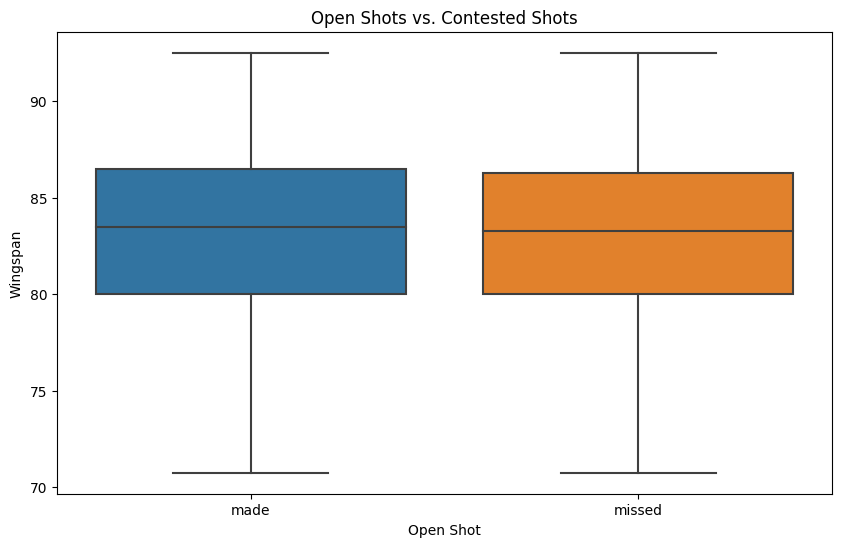

In [257]:
plt.figure(figsize=(10,6))
sns.boxplot(x='shot_result', y='defender_wingspan', data=open_shot)
plt.title('Open Shots vs. Contested Shots')
# plt.xticks([0,1],['Contested','Open'])
plt.xlabel('Open Shot')
plt.ylabel('Wingspan')
plt.show()

The wingspan of the defender does not have much impact on whether the shot goes in or not.

In [258]:
smf.ols('close_def_dist ~ open_shot', data=open_shot).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         close_def_dist   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.070e+05
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:15:34   Log-Likelihood:            -2.7269e+05
No. Observations:              128069   AIC:                         5.454e+05
Df Residuals:                  128067   BIC:                         5.454e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1136      0.008    252.499      0.000       2.097       2.130
open_shot      3.7304      0.011    327.087      0.000       3.708       3.753
==============================================================================
Omnibus:                   120525.225   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11739295.716
Skew:                           4.277   Prob(JB):                         0.00
Kurtosis:                      49.117   Cond. No.                         2.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

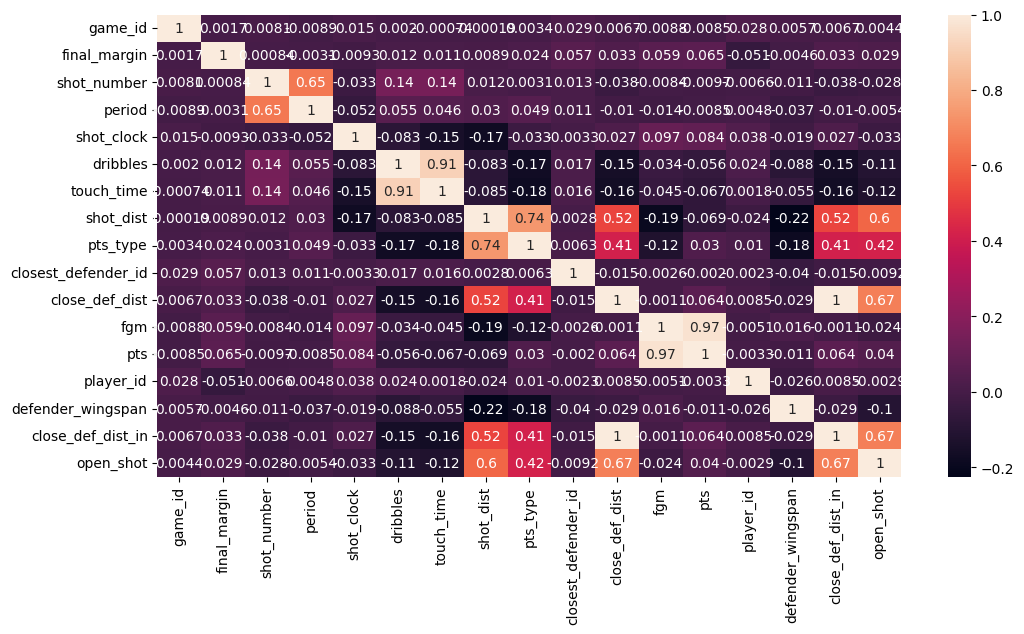

In [259]:
corr_matrix = open_shot.drop(
    columns=open_shot.select_dtypes(
        include=['object']).columns
    ).corr()

plt.figure(figsize=(12,6))
sns.heatmap(data=corr_matrix, annot=True)
plt.show()


In [260]:
t = corr_matrix
t = t.stack().reset_index()
t.columns = ['var1','var2','corr']
t = t[t['var1'] != t['var2']]
t = t.sort_values('corr', ascending=False, key=abs)
t = t.reset_index(drop=True)
t = t.iloc[::2]
t.head()


,var1,var2,corr
0,close_def_dist,close_def_dist_in,1.000000
2,pts,fgm,0.970686
4,touch_time,dribbles,0.914311
6,shot_dist,pts_type,0.740933
8,close_def_dist,open_shot,0.674653


For our purposes we can see that the distance of the closest defender is very strongly correlated with the open_shot value.

## Model

In [261]:
open_shot.columns

Index(['game_id', 'matchup', 'location', 'win', 'final_margin', 'shot_number',
       'period', 'game_clock', 'shot_clock', 'dribbles', 'touch_time',
       'shot_dist', 'pts_type', 'shot_result', 'closest_defender',
       'closest_defender_id', 'close_def_dist', 'fgm', 'pts', 'player_name',
       'player_id', 'defender_wingspan', 'close_def_dist_in', 'open_shot'],
      dtype='object')

In [262]:
open_shot.drop(columns=['fgm'], inplace=True)

In [263]:
open_shot.dtypes

game_id                  int64
matchup                 object
location                object
win                     object
final_margin             int64
shot_number              int64
period                   int64
game_clock              object
shot_clock             float64
dribbles                 int64
touch_time             float64
shot_dist              float64
pts_type                 int64
shot_result             object
closest_defender        object
closest_defender_id      int64
close_def_dist         float64
pts                      int64
player_name             object
player_id                int64
defender_wingspan      float64
close_def_dist_in      float64
open_shot                int64
dtype: object

In [264]:
cat = make_column_selector(dtype_include=['object'])
num = make_column_selector(dtype_include=['int64', 'float64'])

In [265]:
classifiers = [
    ('lr', LogisticRegression()), 
    ('rf', RandomForestClassifier(n_estimators=50)),
]

In [266]:
voting_clf = VotingClassifier(estimators=classifiers, voting='soft')

In [267]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()) 
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num),
        ('cat', cat_transformer, cat)
    ], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', voting_clf)
])

In [268]:
X = open_shot.drop(columns=['shot_result'])
y = open_shot['shot_result']

In [269]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [270]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002B68963BF90>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002B68963B750>)])),
                ('classifier',
                 VotingClassifier(estimators=[('lr', LogisticRegression()),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=50))],
                                  voting='soft'))])

In [271]:
y_pred = pipe.predict(X_test)
y_pred

array(['missed', 'missed', 'made', ..., 'missed', 'made', 'missed'],
      dtype=object)

In [272]:
X_test.columns

Index(['game_id', 'matchup', 'location', 'win', 'final_margin', 'shot_number',
       'period', 'game_clock', 'shot_clock', 'dribbles', 'touch_time',
       'shot_dist', 'pts_type', 'closest_defender', 'closest_defender_id',
       'close_def_dist', 'pts', 'player_name', 'player_id',
       'defender_wingspan', 'close_def_dist_in', 'open_shot'],
      dtype='object')

## Output

In [273]:
output = pd.DataFrame({'Game': X_test.matchup, 'Player': X_test.player_name,'Shot Result': y_pred})
output.head()

,Game,Player,Shot Result
77944,"DEC 31, 2014 - MIL @ CLE",giannis antetokounmpo,missed
22933,"NOV 08, 2014 - WAS @ IND",marcin gortat,missed
126766,"DEC 05, 2014 - BKN vs. ATL",joe johnson,made
104190,"NOV 07, 2014 - OKC vs. MEM",serge ibaka,missed
82348,"JAN 09, 2015 - MEM @ NOP",mike conley,missed


In [274]:
accuracy_score(y_test, y_pred)

1.0